In [5]:
import matplotlib.pyplot as plt
import numpy as np
import gzip
from sklearn.metrics import accuracy_score, confusion_matrix

# One-hot encoding of the labels
def one_hot_encoding(label_data):
    encoded_labels = np.zeros((label_data.shape[0], 10))
    for i in range(label_data.shape[0]):
        encoded_labels[i][label_data[i]] = 1
    return encoded_labels

# Function to read pixel data from the dataset
def read_pixels(data_path):
    with gzip.open(data_path) as f:
        pixel_data = np.frombuffer(f.read(), 'B', offset=16).astype('float32')
    normalized_pixels = pixel_data / 255

    # Flatten the normalized pixels
    flattened_pixels = normalized_pixels.reshape(-1, 28*28) 
    return flattened_pixels

# Function to read label data from the dataset
def read_labels(data_path):
    with gzip.open(data_path) as f:
        label_data = np.frombuffer(f.read(), 'B', offset=8)
    one_hot_encoding_labels = one_hot_encoding(label_data)
    return one_hot_encoding_labels

# Function to read the entire dataset
def read_dataset():
    X_train = read_pixels("data/train-images-idx3-ubyte.gz")
    y_train = read_labels("data/train-labels-idx1-ubyte.gz")
    X_test = read_pixels("data/t10k-images-idx3-ubyte.gz")
    y_test = read_labels("data/t10k-labels-idx1-ubyte.gz")

    # train and validation split
    X_val = X_train[:10000]
    y_val = y_train[:10000]
    X_train = X_train[10000:]
    y_train = y_train[10000:]

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = read_dataset()

softmax = lambda z: np.exp(z - np.max(z, axis=1, keepdims=True)) / np.sum(np.exp(z - np.max(z, axis=1, keepdims=True)), axis=1, keepdims=True)

L2_regularization = lambda weight_matrix, lambda_value: (lambda_value / 2) * np.sum(np.square(weight_matrix))

normal_weight_initializer = lambda input_size, output_size: np.random.normal(0, 1, (input_size, output_size))
zero_weight_initializer = lambda input_size, output_size: np.zeros((input_size, output_size))
uniform_weight_initializer = lambda input_size, output_size: np.random.uniform(size=(input_size, output_size))

def train_logistic_regression(X_train, y_train, X_val, y_val, learning_rate, lambda_value, batch_size, weight_initializer):
    num_epochs = 100
    weight_matrix = weight_initializer(X_train.shape[1], y_train.shape[1])

    val_accuracy_values = []

    # train the model for num_epochs
    for epoch in range(num_epochs):
        # calculate the number of batches
        num_batches = X_train.shape[0] // batch_size

        # train the model for each batch
        for batch in range(num_batches):
            # get the start and end indices for the current batch
            start_index = batch * batch_size
            end_index = (batch + 1) * batch_size

            # get the current batch data and labels
            X_train_batch = X_train[start_index:end_index]
            y_train_batch = y_train[start_index:end_index]

            # calculate the predictions
            predictions = softmax(np.dot(X_train_batch, weight_matrix))

            # calculate the loss
            loss = -np.sum(y_train_batch * np.log(predictions + 1e-8 )) / len(X_train_batch) + L2_regularization(weight_matrix, lambda_value)

            # calculate the gradients
            weight_gradients = np.dot(X_train_batch.T, (predictions - y_train_batch)) + lambda_value * weight_matrix

            # update the weight matrix and bias vector
            weight_matrix -= learning_rate * weight_gradients

        val_prediction = softmax(np.dot(X_val, weight_matrix))
        val_accuracy = accuracy_score(np.argmax(val_prediction, axis=1), np.argmax(y_val, axis=1))
        val_accuracy_values.append(val_accuracy)


        # print the epoch number, validation accuracy in percent and loss value
        print("Epoch: %d, Validation Accuracy: %.2f%%, Loss: %.4f" % (epoch + 1, val_accuracy * 100, loss))

    return weight_matrix, val_accuracy_values



def min_max_normalization(data):
    minimum_value = np.min(data)
    maximum_value = np.max(data)

    normalized_data = (data - minimum_value) / (maximum_value - minimum_value)

    return normalized_data


X_train_min_max = min_max_normalization(X_train)
X_val_min_max = min_max_normalization(X_val)
X_test_min_max = min_max_normalization(X_test)

# default values
learning_rate = 5e-4
lambda_value = 1e-4
batch_size = 200
weight_matrix_init = normal_weight_initializer
bias_vector = np.zeros((1, y_train.shape[1]))

# train the model
weight_matrix, val_accuracy_values = train_logistic_regression(X_train_min_max, y_train, X_val_min_max, y_val, learning_rate, lambda_value, batch_size, weight_matrix_init)

Epoch: 1, Validation Accuracy: 64.93%, Loss: 1.7042
Epoch: 2, Validation Accuracy: 74.16%, Loss: 1.0608
Epoch: 3, Validation Accuracy: 78.21%, Loss: 0.8602
Epoch: 4, Validation Accuracy: 80.79%, Loss: 0.7658
Epoch: 5, Validation Accuracy: 82.20%, Loss: 0.7162
Epoch: 6, Validation Accuracy: 83.20%, Loss: 0.6877
Epoch: 7, Validation Accuracy: 83.72%, Loss: 0.6700
Epoch: 8, Validation Accuracy: 84.26%, Loss: 0.6580
Epoch: 9, Validation Accuracy: 84.67%, Loss: 0.6494
Epoch: 10, Validation Accuracy: 85.21%, Loss: 0.6428
Epoch: 11, Validation Accuracy: 85.52%, Loss: 0.6374
Epoch: 12, Validation Accuracy: 85.78%, Loss: 0.6328
Epoch: 13, Validation Accuracy: 85.99%, Loss: 0.6285
Epoch: 14, Validation Accuracy: 86.27%, Loss: 0.6246
Epoch: 15, Validation Accuracy: 86.41%, Loss: 0.6208
Epoch: 16, Validation Accuracy: 86.61%, Loss: 0.6171
Epoch: 17, Validation Accuracy: 86.76%, Loss: 0.6135
Epoch: 18, Validation Accuracy: 86.92%, Loss: 0.6100
Epoch: 19, Validation Accuracy: 87.03%, Loss: 0.6065
Ep

In [6]:
# calculation of the predictions for the validation data
validation_prediction = np.argmax(softmax(np.dot(X_val_min_max, weight_matrix)), axis=1)

# calculation of the predictions for the test data
test_prediction = np.argmax(softmax(np.dot(X_test_min_max, weight_matrix)), axis=1)

confusion_matrix_validation = confusion_matrix(np.argmax(y_val, axis=1), validation_prediction)
confusion_matrix_test = confusion_matrix(np.argmax(y_test, axis=1), test_prediction)

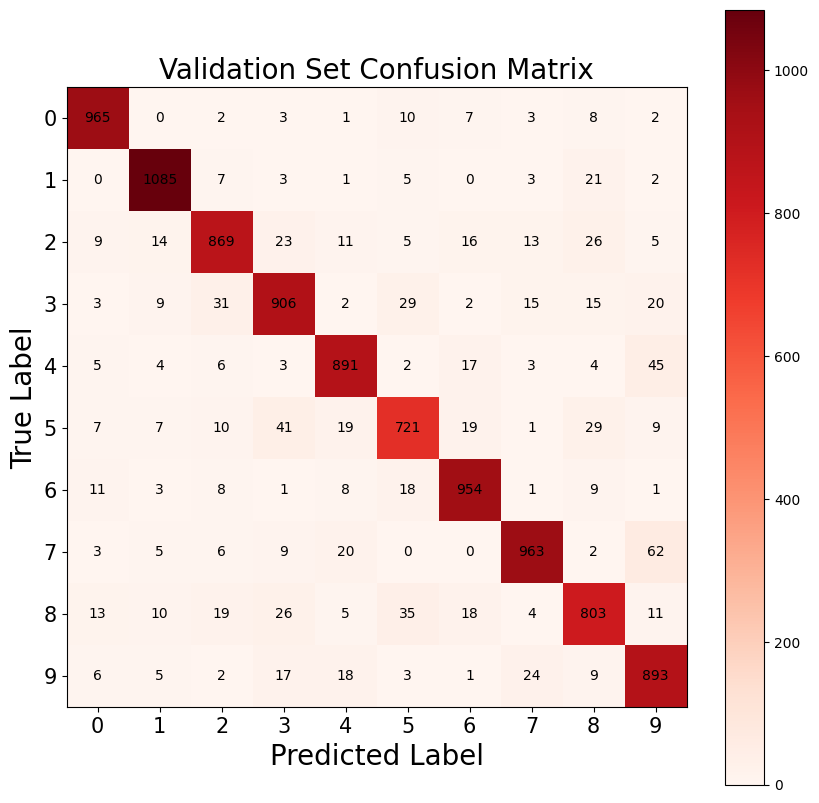

Validation Accuracy: 90.50%


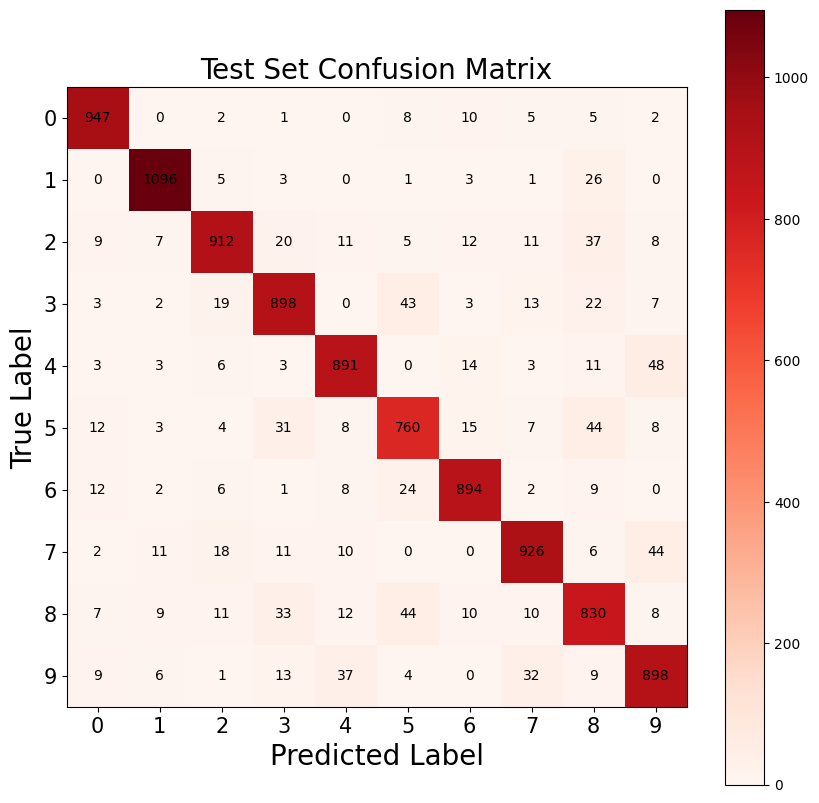

Test Accuracy: 90.52%


In [7]:
def displayConfusionAndValidationAccuracy(confusion_matrix, prediction, type):
    plt.matshow(confusion_matrix, cmap=plt.cm.Reds)
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, range(10))
    plt.yticks(tick_marks, range(10))

    plt.title(type + " Set Confusion Matrix")
    plt.gca().xaxis.tick_bottom()
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.gcf().set_size_inches(10, 10)
    plt.gca().xaxis.label.set_size(20)
    plt.gca().yaxis.label.set_size(20)
    plt.gca().xaxis.set_tick_params(labelsize=15)
    plt.gca().yaxis.set_tick_params(labelsize=15)
    plt.gca().title.set_size(20)

    plt.colorbar()

    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(i, j, str(confusion_matrix[j][i]), horizontalalignment="center", verticalalignment="center")

    plt.show()
    print(type + " Accuracy: %.2f%%" % (accuracy_score(np.argmax(y_val if type == "Validation" else y_test, axis=1), prediction) * 100))

displayConfusionAndValidationAccuracy(confusion_matrix_validation, validation_prediction, "Validation")
displayConfusionAndValidationAccuracy(confusion_matrix_test, test_prediction, "Test")

Epoch: 1, Validation Accuracy: 63.55%, Loss: 0.3793
Epoch: 2, Validation Accuracy: 74.55%, Loss: 0.3742
Epoch: 3, Validation Accuracy: 78.78%, Loss: 0.3700
Epoch: 4, Validation Accuracy: 80.87%, Loss: 0.3663
Epoch: 5, Validation Accuracy: 82.21%, Loss: 0.3627
Epoch: 6, Validation Accuracy: 83.44%, Loss: 0.3594
Epoch: 7, Validation Accuracy: 84.41%, Loss: 0.3562
Epoch: 8, Validation Accuracy: 84.90%, Loss: 0.3531
Epoch: 9, Validation Accuracy: 85.35%, Loss: 0.3502
Epoch: 10, Validation Accuracy: 85.81%, Loss: 0.3473
Epoch: 11, Validation Accuracy: 86.18%, Loss: 0.3446
Epoch: 12, Validation Accuracy: 86.57%, Loss: 0.3419
Epoch: 13, Validation Accuracy: 86.82%, Loss: 0.3393
Epoch: 14, Validation Accuracy: 87.04%, Loss: 0.3369
Epoch: 15, Validation Accuracy: 87.23%, Loss: 0.3345
Epoch: 16, Validation Accuracy: 87.34%, Loss: 0.3322
Epoch: 17, Validation Accuracy: 87.59%, Loss: 0.3301
Epoch: 18, Validation Accuracy: 87.58%, Loss: 0.3280
Epoch: 19, Validation Accuracy: 87.78%, Loss: 0.3261
Ep

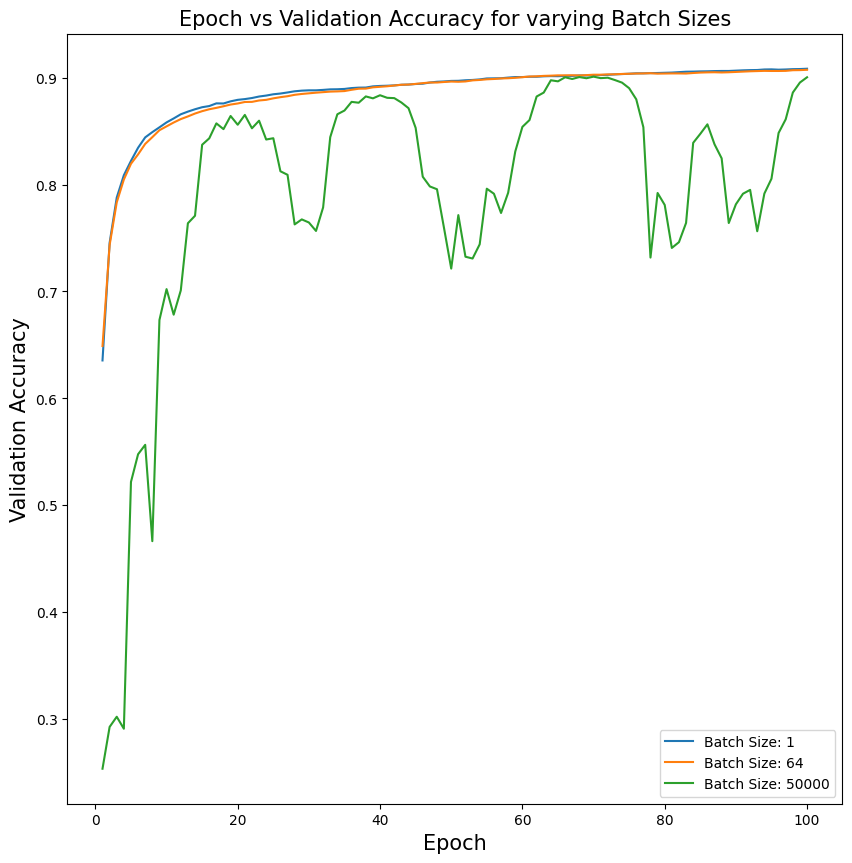

In [8]:
from matplotlib.pyplot import plot


batch_sizes = [1, 64, 50000]
weight_init_techs = [zero_weight_initializer, uniform_weight_initializer, normal_weight_initializer]
learning_rates = [0.1, 1e-3, 1e-4, 1e-5]
lambda_values = [1e-2, 1e-4, 1e-9]
epoch_no = 100

def plot_graph(x, y, x_label, y_label, title, x_ticks):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)	
    plt.legend(loc="lower right")
    plt.gca().xaxis.tick_bottom()
    plt.gca().yaxis.tick_left()
    plt.gca().xaxis.label.set_size(15)
    plt.gca().yaxis.label.set_size(15)
    plt.gca().title.set_size(15)
    plt.gca().xaxis.set_tick_params(labelsize=10)
    plt.gca().yaxis.set_tick_params(labelsize=10)
    plt.gcf().set_size_inches(10, 10)
    plt.show()


# train the model for each batch size others should be default
for batch_size_loop in batch_sizes:
    weight_matrix, val_accuracy_values = train_logistic_regression(X_train_min_max,
     y_train, X_val_min_max, y_val, learning_rate, lambda_value, batch_size_loop, weight_matrix_init)
    # plot the validation accuracy values
    plt.plot(range(1, epoch_no + 1), val_accuracy_values, label="Batch Size: %d" % batch_size_loop)

# display the plot
plot_graph(range(1, epoch_no + 1), val_accuracy_values, "Epoch", "Validation Accuracy", "Epoch vs Validation Accuracy for varying Batch Sizes", range(1, len(val_accuracy_values) + 1))


Epoch: 1, Validation Accuracy: 88.10%, Loss: 0.3218
Epoch: 2, Validation Accuracy: 89.39%, Loss: 0.2571
Epoch: 3, Validation Accuracy: 90.05%, Loss: 0.2323
Epoch: 4, Validation Accuracy: 90.40%, Loss: 0.2187
Epoch: 5, Validation Accuracy: 90.65%, Loss: 0.2099
Epoch: 6, Validation Accuracy: 90.90%, Loss: 0.2037
Epoch: 7, Validation Accuracy: 91.01%, Loss: 0.1990
Epoch: 8, Validation Accuracy: 91.08%, Loss: 0.1953
Epoch: 9, Validation Accuracy: 91.21%, Loss: 0.1922
Epoch: 10, Validation Accuracy: 91.30%, Loss: 0.1895
Epoch: 11, Validation Accuracy: 91.44%, Loss: 0.1873
Epoch: 12, Validation Accuracy: 91.49%, Loss: 0.1853
Epoch: 13, Validation Accuracy: 91.52%, Loss: 0.1835
Epoch: 14, Validation Accuracy: 91.54%, Loss: 0.1820
Epoch: 15, Validation Accuracy: 91.60%, Loss: 0.1805
Epoch: 16, Validation Accuracy: 91.68%, Loss: 0.1792
Epoch: 17, Validation Accuracy: 91.72%, Loss: 0.1780
Epoch: 18, Validation Accuracy: 91.76%, Loss: 0.1769
Epoch: 19, Validation Accuracy: 91.80%, Loss: 0.1759
Ep

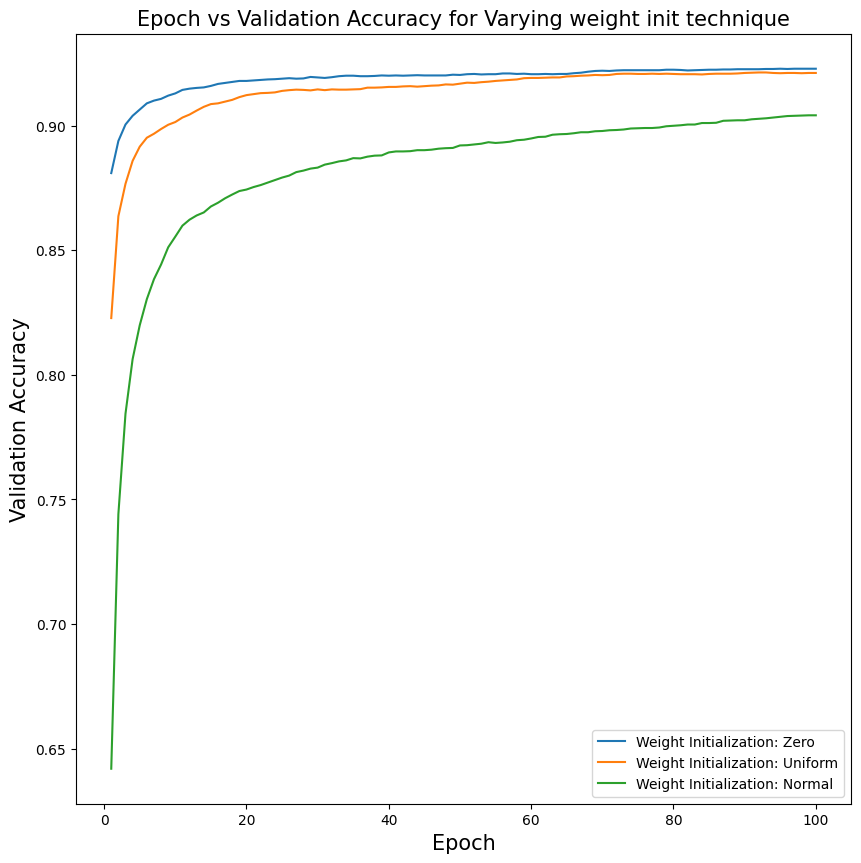

In [9]:
weight_init_names = ["Zero", "Uniform", "Normal"]
cnt = 0
batch_size = 200
for weight_matrix_init_loop in weight_init_techs:
    weight_matrix, val_accuracy_values = train_logistic_regression(X_train_min_max,
     y_train, X_val_min_max, y_val, learning_rate, lambda_value, batch_size, weight_matrix_init_loop)
    plt.plot(range(1, epoch_no + 1), val_accuracy_values, label="Weight Initialization: %s" % weight_init_names[cnt])
    cnt += 1

plot_graph(range(1, epoch_no + 1), val_accuracy_values, "Epoch", "Validation Accuracy", "Epoch vs Validation Accuracy for Varying weight init technique", range(1, len(val_accuracy_values) + 1))

Epoch: 1, Validation Accuracy: 87.02%, Loss: 2.0954
Epoch: 2, Validation Accuracy: 87.14%, Loss: 2.2519
Epoch: 3, Validation Accuracy: 88.20%, Loss: 2.6823
Epoch: 4, Validation Accuracy: 88.17%, Loss: 2.4884
Epoch: 5, Validation Accuracy: 87.83%, Loss: 2.5745
Epoch: 6, Validation Accuracy: 88.53%, Loss: 2.8612
Epoch: 7, Validation Accuracy: 87.82%, Loss: 3.6236
Epoch: 8, Validation Accuracy: 87.99%, Loss: 2.9600
Epoch: 9, Validation Accuracy: 87.87%, Loss: 3.3402
Epoch: 10, Validation Accuracy: 88.84%, Loss: 3.3961
Epoch: 11, Validation Accuracy: 88.67%, Loss: 3.7536
Epoch: 12, Validation Accuracy: 88.04%, Loss: 3.7565
Epoch: 13, Validation Accuracy: 88.01%, Loss: 3.7487
Epoch: 14, Validation Accuracy: 89.27%, Loss: 4.1914
Epoch: 15, Validation Accuracy: 87.73%, Loss: 4.1515
Epoch: 16, Validation Accuracy: 87.78%, Loss: 4.2341
Epoch: 17, Validation Accuracy: 87.71%, Loss: 4.4339
Epoch: 18, Validation Accuracy: 86.14%, Loss: 5.1128
Epoch: 19, Validation Accuracy: 89.05%, Loss: 4.4953
Ep

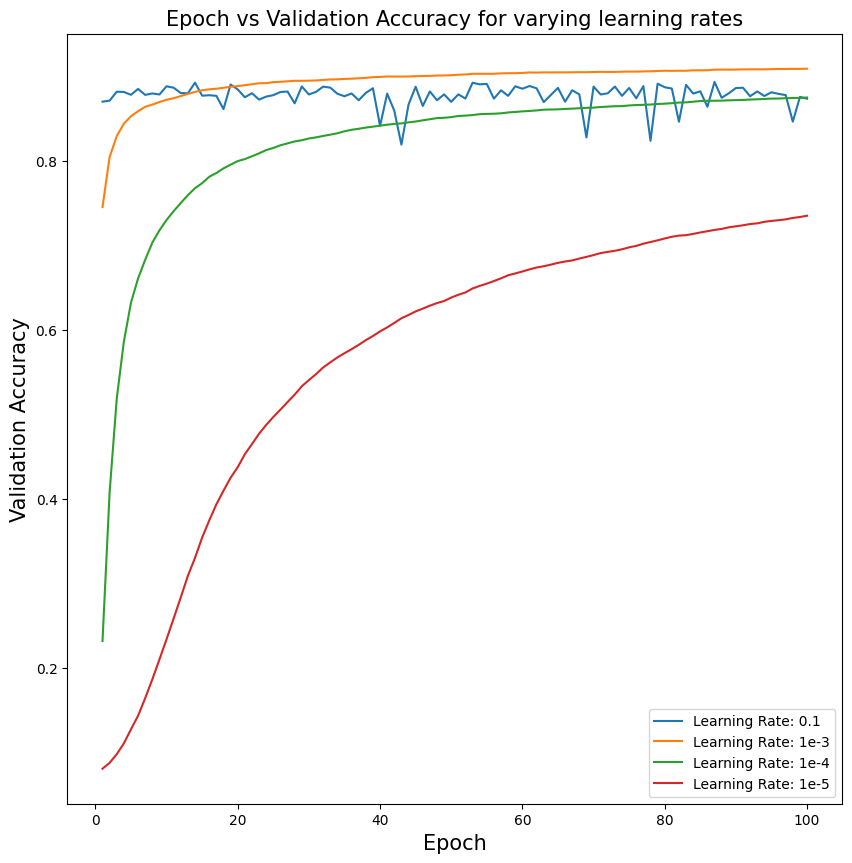

In [10]:
learning_rate_names = ["0.1", "1e-3", "1e-4", "1e-5"]
cnt = 0
for learning_rate_loop in learning_rates:
    weight_matrix, val_accuracy_values = train_logistic_regression(X_train_min_max,
     y_train, X_val_min_max, y_val, learning_rate_loop, lambda_value, batch_size, weight_matrix_init)
    plt.plot(range(1, epoch_no + 1), val_accuracy_values, label="Learning Rate: %s" % learning_rate_names[cnt])
    cnt += 1

plot_graph(range(1, epoch_no + 1), val_accuracy_values, "Epoch", "Validation Accuracy", "Epoch vs Validation Accuracy for varying learning rates", range(1, len(val_accuracy_values) + 1))

Epoch: 1, Validation Accuracy: 66.14%, Loss: 39.8877
Epoch: 2, Validation Accuracy: 75.58%, Loss: 38.9457
Epoch: 3, Validation Accuracy: 79.11%, Loss: 38.4506
Epoch: 4, Validation Accuracy: 81.16%, Loss: 38.0890
Epoch: 5, Validation Accuracy: 82.36%, Loss: 37.7829
Epoch: 6, Validation Accuracy: 83.17%, Loss: 37.5055
Epoch: 7, Validation Accuracy: 83.84%, Loss: 37.2473
Epoch: 8, Validation Accuracy: 84.45%, Loss: 37.0038
Epoch: 9, Validation Accuracy: 84.88%, Loss: 36.7719
Epoch: 10, Validation Accuracy: 85.43%, Loss: 36.5497
Epoch: 11, Validation Accuracy: 85.82%, Loss: 36.3355
Epoch: 12, Validation Accuracy: 86.11%, Loss: 36.1282
Epoch: 13, Validation Accuracy: 86.29%, Loss: 35.9269
Epoch: 14, Validation Accuracy: 86.51%, Loss: 35.7310
Epoch: 15, Validation Accuracy: 86.62%, Loss: 35.5398
Epoch: 16, Validation Accuracy: 86.79%, Loss: 35.3529
Epoch: 17, Validation Accuracy: 86.95%, Loss: 35.1699
Epoch: 18, Validation Accuracy: 87.11%, Loss: 34.9905
Epoch: 19, Validation Accuracy: 87.17

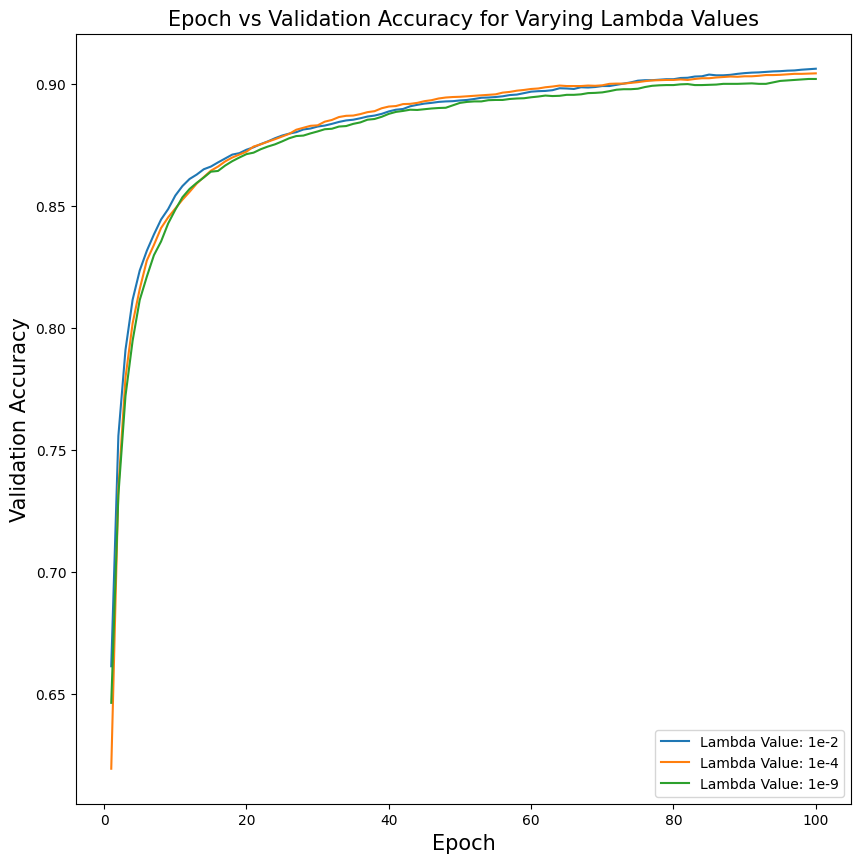

In [11]:
cnt = 0
batch_size = 200
lambda_value_names = ["1e-2", "1e-4", "1e-9"]
for lambda_value_loop in lambda_values:
    weight_matrix, val_accuracy_values = train_logistic_regression(X_train_min_max,
     y_train, X_val_min_max, y_val, learning_rate, lambda_value_loop, batch_size, weight_matrix_init)
    plt.plot(range(1, epoch_no + 1), val_accuracy_values, label=f"Lambda Value: {lambda_value_names[cnt]}")
    cnt += 1

plot_graph(range(1, epoch_no + 1), val_accuracy_values, "Epoch", "Validation Accuracy", "Epoch vs Validation Accuracy for Varying Lambda Values", range(1, len(val_accuracy_values) + 1))

Epoch: 1, Validation Accuracy: 89.76%, Loss: 0.5222
Epoch: 2, Validation Accuracy: 90.67%, Loss: 0.5289
Epoch: 3, Validation Accuracy: 91.16%, Loss: 0.5568
Epoch: 4, Validation Accuracy: 91.37%, Loss: 0.5868
Epoch: 5, Validation Accuracy: 91.50%, Loss: 0.6157
Epoch: 6, Validation Accuracy: 91.63%, Loss: 0.6428
Epoch: 7, Validation Accuracy: 91.72%, Loss: 0.6684
Epoch: 8, Validation Accuracy: 91.81%, Loss: 0.6924
Epoch: 9, Validation Accuracy: 91.85%, Loss: 0.7150
Epoch: 10, Validation Accuracy: 91.89%, Loss: 0.7365
Epoch: 11, Validation Accuracy: 91.93%, Loss: 0.7570
Epoch: 12, Validation Accuracy: 92.01%, Loss: 0.7765
Epoch: 13, Validation Accuracy: 91.97%, Loss: 0.7952
Epoch: 14, Validation Accuracy: 92.00%, Loss: 0.8132
Epoch: 15, Validation Accuracy: 92.03%, Loss: 0.8305
Epoch: 16, Validation Accuracy: 92.04%, Loss: 0.8471
Epoch: 17, Validation Accuracy: 92.04%, Loss: 0.8633
Epoch: 18, Validation Accuracy: 92.03%, Loss: 0.8788
Epoch: 19, Validation Accuracy: 92.04%, Loss: 0.8939
Ep

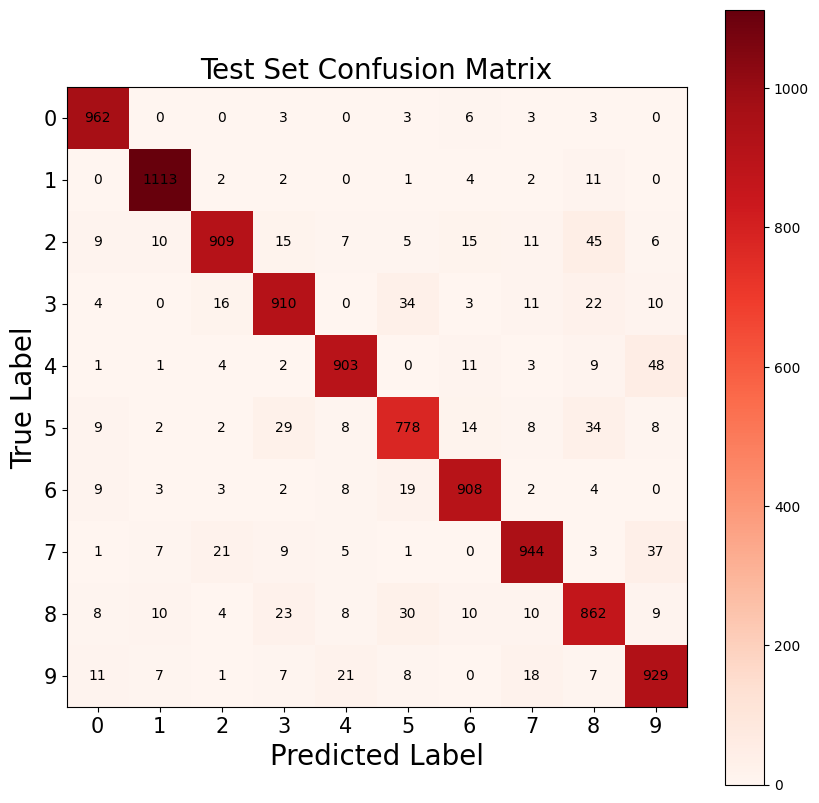

Test Accuracy: 92.18%


In [12]:
# Question 2.3 [5 pts] After you perform the above experiments, you need to select the best values for each
# of the hyperparameters (and the best-performing initialization technique for weights) and create the optimal
# model. You need to display the test accuracy and confusion matrix for the best model.

# best values for each hyperparameter
batch_size = 64
weight_matrix_init = zero_weight_initializer
learning_rate = 1e-3
lambda_value = 1e-2

# train the model
# test set will be used for the final evaluation, then merge the train and validation set
X_train = np.concatenate((X_train, X_val), axis=0)
y_train = np.concatenate((y_train, y_val), axis=0)

# train the model with the best hyperparameters
weight_matrix, val_accuracy_values = train_logistic_regression(X_train_min_max,
 y_train, X_test_min_max, y_test, learning_rate, lambda_value, batch_size, weight_matrix_init)

# prediction for the test set
test_prediction = np.argmax(softmax(np.dot(X_test_min_max, weight_matrix)), axis=1)

confusion_matrix_test = confusion_matrix(np.argmax(y_test, axis=1), test_prediction)
displayConfusionAndValidationAccuracy(confusion_matrix_test, test_prediction, "Test")



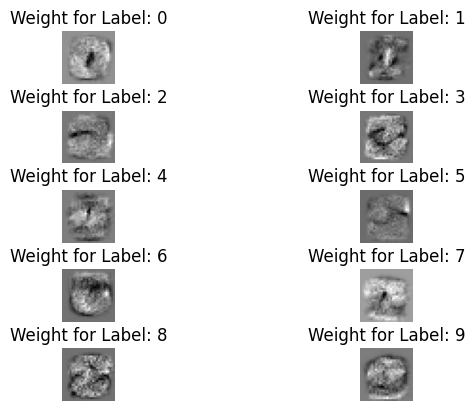

In [21]:
# Question 2.4 [10 pts]

# Create subplots
fig, axes = plt.subplots(5, 2)

# Reshape the weight matrix
weight_matrix = weight_matrix.reshape(28, 28, 10)

# Plot the weight matrix
for i, ax in enumerate(axes.flat):
    ax.imshow(weight_matrix[:, :, i], cmap="gray")
    ax.set_title("Weight for Label: %d" % i)
    ax.axis("off")

# Adjust spacing between subplots
plt.subplots_adjust(hspace=0.5, wspace=0.5)

# Display the plot
plt.show()

In [24]:
# Question 2.5 [5 pts] Using the best model, calculate precision, recall, F1 score and F2 score for each class.
# Comment on the results using the confusion matrix you obtained in Question 2.3 and the weight images you
# obtained in Question 2.4.

# precision, recall, F1 score and F2 score for each class
from sklearn.metrics import precision_score, recall_score, f1_score, fbeta_score

# precision, recall, F1 score and F2 score for each class
precision = precision_score(np.argmax(y_test, axis=1), test_prediction, average=None)
recall = recall_score(np.argmax(y_test, axis=1), test_prediction, average=None)
f1 = f1_score(np.argmax(y_test, axis=1), test_prediction, average=None)
f2 = fbeta_score(np.argmax(y_test, axis=1), test_prediction, beta=2, average=None)

for i in range(10):
    print("Class: %d, Precision: %.2f, Recall: %.2f, F1 Score: %.2f, F2 Score: %.2f" % (i, precision[i], recall[i], f1[i], f2[i]))

Class: 0, Precision: 0.95, Recall: 0.98, F1 Score: 0.96, F2 Score: 0.97
Class: 1, Precision: 0.97, Recall: 0.98, F1 Score: 0.97, F2 Score: 0.98
Class: 2, Precision: 0.94, Recall: 0.88, F1 Score: 0.91, F2 Score: 0.89
Class: 3, Precision: 0.91, Recall: 0.90, F1 Score: 0.90, F2 Score: 0.90
Class: 4, Precision: 0.94, Recall: 0.92, F1 Score: 0.93, F2 Score: 0.92
Class: 5, Precision: 0.89, Recall: 0.87, F1 Score: 0.88, F2 Score: 0.87
Class: 6, Precision: 0.94, Recall: 0.95, F1 Score: 0.94, F2 Score: 0.95
Class: 7, Precision: 0.93, Recall: 0.92, F1 Score: 0.93, F2 Score: 0.92
Class: 8, Precision: 0.86, Recall: 0.89, F1 Score: 0.87, F2 Score: 0.88
Class: 9, Precision: 0.89, Recall: 0.92, F1 Score: 0.90, F2 Score: 0.91
